Only reading in one email for now

In [1]:
enroncsv = "../experiments/data/enron.csv"
metadataHeaders = '../experiments/data/metadataHeaders.csv'

In [ ]:
import pandas as pd

columns = pd.read_csv(metadataHeaders, sep=',').columns.tolist()
columns

In [34]:
df = pd.read_csv(enroncsv, names=columns, sep='|', low_memory=False)

print("-- DONE --")

-- DONE --


Lets query for a mail that does not have `Message-ID` with `.JavaMail.evans@thyme`

In [4]:
result = df[pd.notnull(df['Message-ID'])]

result = result.loc[~result['Message-ID'].str.contains('.JavaMail.evans@thyme')]
result

,Filename,Person,Directory,Message-ID,Date,From,To,Subject,Cc,Time,...,Content-Type,Content-Transfer-Encoding,Bcc,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName


In [5]:
result = df[pd.notnull(df['Subject'])]

result = result.loc[result['Subject'].str.contains('Porn')]
len(result)

25

No results so the server `.JavaMail.evans@thyme` is not helpfull

Lets count the number of non null fields per header and make it a percentage over the total number of parsable emials

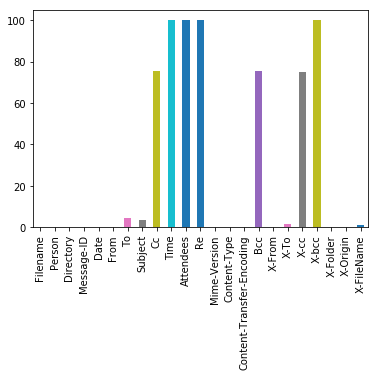

Filename                      0.000000
Person                        0.000000
Directory                     0.000000
Message-ID                    0.000387
Date                          0.000387
From                          0.000387
To                            4.222880
Subject                       3.713189
Cc                           75.279489
Time                         99.999807
Attendees                    99.994201
Re                           99.998840
Mime-Version                  0.011597
Content-Type                  0.011597
Content-Transfer-Encoding     0.010631
Bcc                          75.284322
X-From                        0.011404
X-To                          1.770680
X-cc                         75.084079
X-bcc                        99.959410
X-Folder                      0.012370
X-Origin                      0.006958
X-FileName                    0.820493
dtype: float64

In [19]:
import matplotlib.pyplot as plt

numberOfRows = len(df.index)
missingData = (numberOfRows - df.count()) / numberOfRows * 100
plot = missingData.plot(kind='bar')

plt.show()
missingData

How many people flolders don't match their X-origin

In [7]:
len(df.loc[df['Person'] != df['X-Origin'].str.lower()])

35496

How many different `Content-Type`'s are in the dataset

In [8]:
df['Content-Type'].unique()

array([nan, 'text/plain; charset="us-ascii"',
       'text/plain; charset="ANSI_X3.4-1968"'], dtype=object)

How many different `Content-Transfer-Encoding`'s are in the dataset

In [9]:
df['Content-Transfer-Encoding'].unique()

array([nan, '7bit', 'quoted-printable', 'base64',
       '\\JSKILLIN (Non-Privileged)\\Deleted Items', '\\jskillin\\Inbox',
       '\\HARORA (Non-Privileged)\\Arora, Harry\\Deleted Items',
       '\\HARORA (Non-Privileged)\\Arora, Harry\\Inbox',
       'EID: <24606> ERe: <0>'], dtype=object)

How many different `Mime-Version`'s are in the dataset

In [10]:
df['Mime-Version'].unique()

array([nan,  1.])

Lets gage the the stogasticity

Filename                      15000
Person                          238
Directory                      1765
From                          20327
To                            58554
Subject                      159257
Cc                            29598
Time                              2
Attendees                        17
Re                                5
Mime-Version                      2
Content-Type                      3
Content-Transfer-Encoding         9
Bcc                           29594
X-From                        27789
X-To                          73435
X-cc                          33675
X-bcc                           140
X-Folder                       5355
X-Origin                        289
X-FileName                      436
dtype: int64

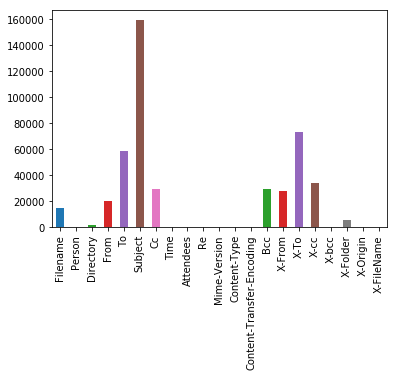

In [31]:
df = df.drop(['Message-ID', 'Date'], axis=1)

headers = df.columns.values.tolist()
uniqueness = []

for header in headers:
    uniqueness.append(len(df[header].unique()))
    
uniqueness = pd.Series(uniqueness, index=headers)

plot = uniqueness.plot(kind='bar')
uniqueness

The graph above indicates that the subject contains he most information of all of the email headers and is the most unique.